In [1]:
import pandas as pd
import numpy as np
import openpyxl 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path



In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) / 'data' /'processed'
external_dir = Path(TOP) / 'data' /'external'
figures_dir = Path(TOP) / 'reports' /'figures'

In [3]:
import genra_nta

In [4]:
from genra_nta.chm.chem import FingerprintGenerator

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
source = pd.read_csv(external_dir/'toxval_wmetab.csv', index_col = [0])

In [7]:
y = source.set_index('dtxsid')['pPOD']

In [8]:
fp_gen_s = FingerprintGenerator()

In [9]:
fp_gen_s.add_chemicals_from_dataframe(source)
source_FP = fp_gen_s.generate_fingerprints()

[17:38:18] WARNING: not removing hydrogen atom without neighbors
[17:38:18] WARNING: not removing hydrogen atom without neighbors
[17:38:18] WARNING: not removing hydrogen atom without neighbors
[17:38:18] WARNING: not removing hydrogen atom without neighbors
[17:38:18] WARNING: not removing hydrogen atom without neighbors
[17:38:18] WARNING: not removing hydrogen atom without neighbors
[17:38:18] WARNING: not removing hydrogen atom without neighbors


In [10]:
X_train, X_test, y_train, y_test = train_test_split(source_FP, y, test_size=0.25,  random_state=42)

In [11]:
from genra_nta.nn.nn import NearestNeighborAnalyzer

In [12]:
analyzer = NearestNeighborAnalyzer(n_neighbors=10, metric='jaccard')

In [13]:
analyzer.train_model(X_train)

In [14]:
mylst = []
for idx in X_train.index.tolist():
    a = analyzer.find_analogues(target_chemical_id = idx, target_df=X_train)
    mylst.append(a)

/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/grace/Documents/python/nts_rax/genra_nta/nn/nn.py:54: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: self.fingerprints.index[idx])
/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/grace/Documents/python/nts_rax/genra_nta/nn/nn.py:54: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: self.fingerprints.index[idx])
/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: Data

In [15]:
mylst[0]

,analogue,jaccard,target
0,DTXSID90883480,1.000000,DTXSID5020077
1,DTXSID5020077,1.000000,DTXSID5020077
2,DTXSID3027297,0.695652,DTXSID5020077
3,DTXSID9021683,0.695652,DTXSID5020077
4,DTXSID6021664,0.533333,DTXSID5020077
5,DTXSID3021641,0.533333,DTXSID5020077
6,DTXSID3026930,0.533333,DTXSID5020077
7,DTXSID8021642,0.533333,DTXSID5020077
8,DTXSID2021602,0.533333,DTXSID5020077
9,DTXSID3021645,0.500000,DTXSID5020077


In [16]:
y_train1 = y_train.reset_index()

In [17]:
from genra_nta.rax.reg.reg import ToxicityPredictor

In [18]:
genra_dict = {}
genra_dict2 = {}
errors = []
for i, df in enumerate(mylst):
    try:
        k = mylst[i]['target'].unique()[0]
        predictor = ToxicityPredictor(analogue_df=df, tox_data=y_train1, similarity_col='jaccard', activity_col='pPOD')
        a =predictor.join_data()
        weighted_avg = predictor.wtavg()
        
    except Exception as e:
        errors.append([i,e])
    genra_dict[k] = weighted_avg
    genra_dict2[k] = a.jaccard.tolist(), a.pPOD.tolist()

In [19]:
#y_train1

In [20]:
train_toxval = (pd.merge(y_train1, pd.DataFrame(list(genra_dict.items()), columns = ['target_dtxsid', 'pred_pPOD']), left_on = 'dtxsid', right_on = 'target_dtxsid')
 .drop(['dtxsid'], axis = 1)
 .assign(residual = lambda x: x['pPOD']-x['pred_pPOD'])
)

In [21]:
from sklearn.metrics import r2_score,root_mean_squared_error

In [22]:
r2_score(train_toxval['pPOD'], train_toxval['pred_pPOD'])

0.2680243582709718

In [23]:
root_mean_squared_error(train_toxval['pPOD'], train_toxval['pred_pPOD'])

0.9092391090398664

In [24]:
import seaborn as sns


<Axes: xlabel='pPOD', ylabel='pred_pPOD'>

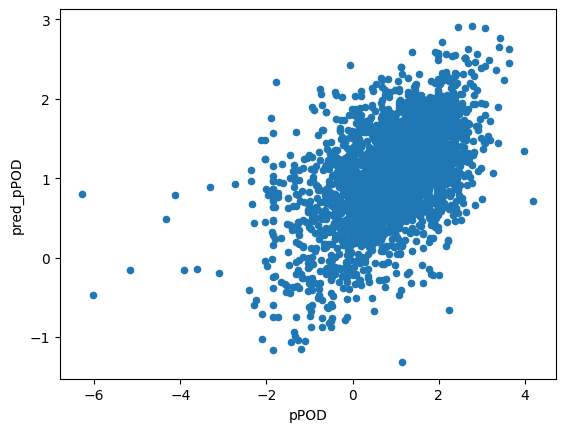

In [25]:
train_toxval.plot(kind = 'scatter', x = 'pPOD', y = 'pred_pPOD')

<Axes: ylabel='Frequency'>

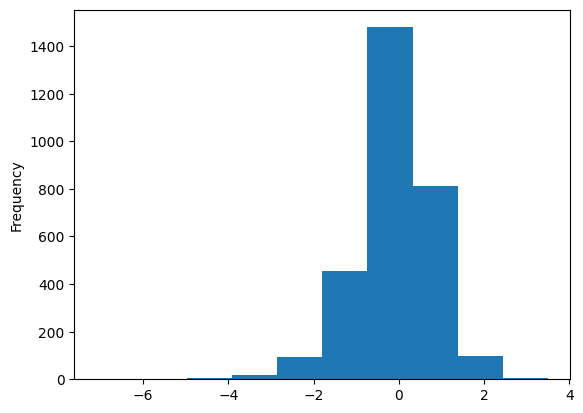

In [26]:
train_toxval['residual'].plot(kind = 'hist')

## Re-try with Embeddings

In [27]:
txval_embeddings_df = pd.read_csv(external_dir/'toxval_rpd_embeddings.csv')

In [28]:
txval_embeddings_df = txval_embeddings_df.set_index('dtxsid')

<Axes: ylabel='dtxsid'>

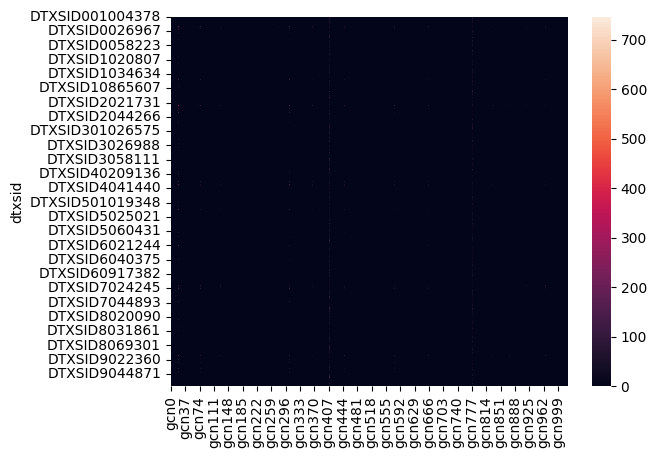

In [29]:
sns.heatmap(txval_embeddings_df)

In [30]:
txval_embeddings_df.to_numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance

In [33]:
embeddings_no_zero_variance = txval_embeddings_df.to_numpy()[:, np.var(txval_embeddings_df.to_numpy(), axis=0) > 1e-6]
cov_matrix = np.cov(embeddings_no_zero_variance, rowvar=False)

inv_cov_matrix = np.linalg.inv(cov_matrix)
mahalanobis_distances = distance.cdist(embeddings_no_zero_variance, embeddings_no_zero_variance, metric='mahalanobis', VI=inv_cov_matrix)

In [35]:
pd.DataFrame(mahalanobis_distances)

,0,1,2,3,4,5,6,7,8,9,...,3948,3949,3950,3951,3952,3953,3954,3955,3956,3957
0,0.000000e+00,5.398764e+05,NaN,NaN,1.951957e+06,482753.503315,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.398764e+05,0.000000e+00,2.412402e+06,NaN,1.238592e+06,NaN,1.174180e+06,NaN,NaN,NaN,...,NaN,4.840652e+05,NaN,NaN,NaN,4.488445e+06,5.940753e+06,1.125823e+06,NaN,NaN
2,NaN,2.412402e+06,0.000000e+00,2.276835e+06,3.799968e+06,NaN,3.496032e+05,2.477995e+06,1.057915e+06,5.148688e+06,...,1.907096e+06,1.714188e+06,2.139646e+06,2.684802e+06,NaN,NaN,7.737142e+05,8.534558e+05,NaN,3.032361e+06
3,NaN,NaN,2.276835e+06,0.000000e+00,NaN,NaN,NaN,NaN,7.598477e+05,2.858395e+06,...,NaN,NaN,NaN,NaN,NaN,6.527210e+06,8.665532e+06,NaN,NaN,4.449788e+05
4,1.951957e+06,1.238592e+06,3.799968e+06,NaN,0.000000e+00,NaN,2.415292e+06,1.304289e+06,NaN,NaN,...,1.828845e+06,1.729328e+06,1.660180e+06,NaN,NaN,6.615530e+06,8.417711e+06,2.364588e+06,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,NaN,4.488445e+06,NaN,6.527210e+06,6.615530e+06,NaN,NaN,5.128793e+06,5.732357e+06,1.096884e+07,...,4.566160e+06,3.180394e+06,4.542738e+06,6.078476e+06,NaN,0.000000e+00,1.148111e+06,1.324419e+06,6.107567e+06,6.977347e+06
3954,NaN,5.940753e+06,7.737142e+05,8.665532e+06,8.417711e+06,692221.668974,1.269195e+06,6.765587e+06,7.788191e+06,1.403782e+07,...,6.146775e+06,4.428299e+06,6.070340e+06,7.982818e+06,NaN,1.148111e+06,0.000000e+00,2.508903e+06,8.583129e+06,9.111937e+06
3955,NaN,1.125823e+06,8.534558e+05,NaN,2.364588e+06,NaN,NaN,5.341895e+05,NaN,1.055348e+06,...,NaN,6.207991e+05,NaN,NaN,NaN,1.324419e+06,2.508903e+06,0.000000e+00,NaN,NaN
3956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.592567e+06,...,NaN,NaN,NaN,NaN,NaN,6.107567e+06,8.583129e+06,NaN,0.000000e+00,NaN


In [36]:
from sklearn.metrics.pairwise import euclidean_distances

# Compute Euclidean distance
distance_matrix = euclidean_distances(txval_embeddings_df.to_numpy())

In [51]:
# Min-max normalization
min_dist = np.min(distance_matrix)
max_dist = np.max(distance_matrix)

if max_dist - min_dist > 0:
    D_euc1 = (distance_matrix - min_dist) / (max_dist - min_dist)
else:
    D_euc1 = np.zeros_like(distance_matrix)  # Edge case where all distances are identical


In [53]:
#D_euc1

In [54]:
D_euc = pd.DataFrame(D_euc1, index = txval_embeddings_df.index, columns =txval_embeddings_df.index)

In [55]:
train_ids = X_train.index.tolist()

In [56]:
len(train_ids)

2968

In [57]:
D_euc1 = D_euc.loc[train_ids, train_ids]

<Axes: xlabel='dtxsid', ylabel='dtxsid'>

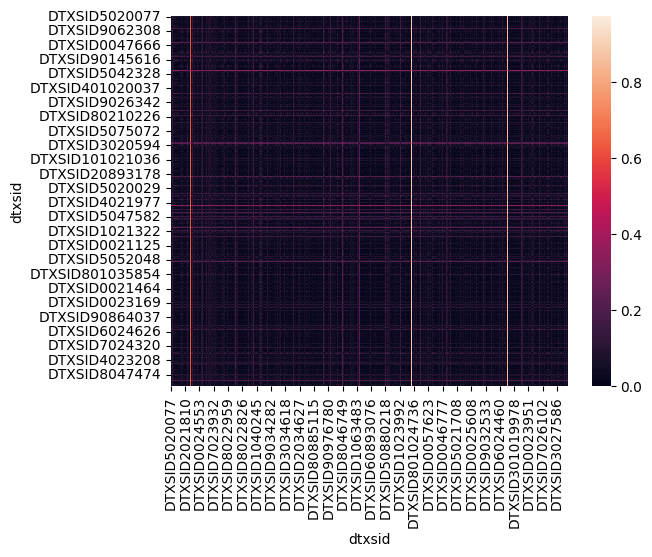

In [58]:
sns.heatmap(D_euc1)

In [44]:
from genra_nta.nn.nn import NearestNeighborAnalyzer

In [45]:
analyzer_emb = NearestNeighborAnalyzer(n_neighbors=10, metric='precomputed')
analyzer_emb.train_model(D_euc1)



In [59]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(metric="precomputed", n_neighbors=10)  # Adjust neighbors as needed
nbrs = nn.fit(D_euc1)





In [60]:
def make_analogue(m, FP, target_df, dtx):
    dist, indices = m.kneighbors(target_df.loc[[dtx]])
    neighbour_indices_df = pd.DataFrame(indices)
    sims = 1 - dist
    neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.index[idx])
    analogue_df = pd.concat([neighbour_labels_df.T, pd.DataFrame(sims).T], axis = 1)
    analogue_df['target'] = dtx
    analogue_df.columns = ['analogue', 'jaccard', 'target']
    return analogue_df

In [61]:
mylst_emb = []
for idx in X_train.index.tolist():
    a = make_analogue(m = nbrs, FP = D_euc1, target_df = D_euc1, dtx = idx)
    mylst_emb.append(a)

/tmp/ipykernel_505297/2117032366.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.index[idx])
/tmp/ipykernel_505297/2117032366.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.index[idx])
/tmp/ipykernel_505297/2117032366.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.index[idx])
/tmp/ipykernel_505297/2117032366.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.index[idx])
/tmp/ipykernel_505297/2117032366.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.in

In [62]:
mylst[0]

,analogue,jaccard,target
0,DTXSID90883480,1.000000,DTXSID5020077
1,DTXSID5020077,1.000000,DTXSID5020077
2,DTXSID3027297,0.695652,DTXSID5020077
3,DTXSID9021683,0.695652,DTXSID5020077
4,DTXSID6021664,0.533333,DTXSID5020077
5,DTXSID3021641,0.533333,DTXSID5020077
6,DTXSID3026930,0.533333,DTXSID5020077
7,DTXSID8021642,0.533333,DTXSID5020077
8,DTXSID2021602,0.533333,DTXSID5020077
9,DTXSID3021645,0.500000,DTXSID5020077


In [63]:
mylst_emb[1]

,analogue,jaccard,target
0,DTXSID7023194,1.000000,DTXSID7023194
1,DTXSID8027614,0.998764,DTXSID7023194
2,DTXSID5025156,0.998320,DTXSID7023194
3,DTXSID3052488,0.998280,DTXSID7023194
4,DTXSID20275859,0.998093,DTXSID7023194
5,DTXSID3034909,0.997647,DTXSID7023194
6,DTXSID20190891,0.997603,DTXSID7023194
7,DTXSID5023748,0.997413,DTXSID7023194
8,DTXSID2021731,0.997365,DTXSID7023194
9,DTXSID50893843,0.997222,DTXSID7023194


In [64]:
genra_dict2 = {}

errors = []
for i, df in enumerate(mylst_emb):
    try:
        k = mylst_emb[i]['target'].unique()[0]
        predictor = ToxicityPredictor(analogue_df=df, tox_data=y_train1, similarity_col='jaccard', activity_col='pPOD')
        a =predictor.join_data()
        weighted_avg = predictor.wtavg()
        
    except Exception as e:
        errors.append([i,e])
    genra_dict2[k] = weighted_avg
    

In [65]:
embed_toxval = (pd.merge(y_train1, pd.DataFrame(list(genra_dict2.items()), columns = ['target_dtxsid', 'pred_pPOD']), left_on = 'dtxsid', right_on = 'target_dtxsid')
 .drop(['dtxsid'], axis = 1)
 .assign(residual = lambda x: x['pPOD']-x['pred_pPOD'])
)

In [66]:
embed_toxval
r2_score(embed_toxval['pPOD'], embed_toxval['pred_pPOD'])

0.42512351555589256

In [67]:
root_mean_squared_error(embed_toxval['pPOD'], embed_toxval['pred_pPOD'])

0.8057810788838692

<Axes: xlabel='pPOD', ylabel='pred_pPOD'>

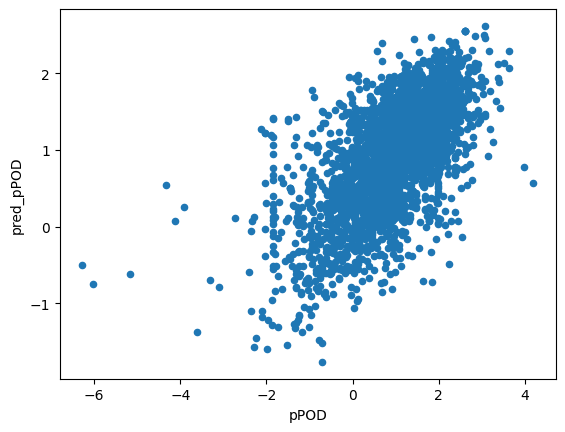

In [68]:
embed_toxval.plot(kind = 'scatter', x = 'pPOD', y = 'pred_pPOD')


<Axes: ylabel='Frequency'>

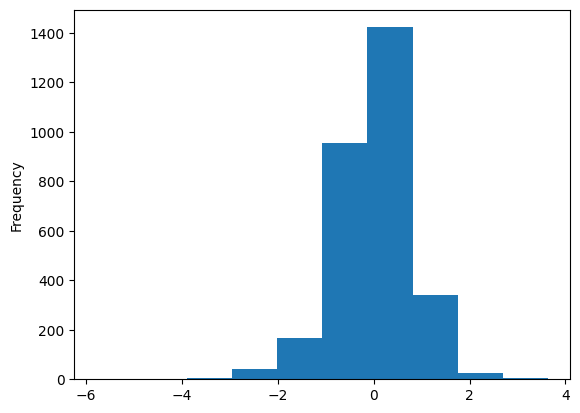

In [69]:
embed_toxval['residual'].plot(kind = 'hist')